Taken from official tutorial here : https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html

In [2]:
!wget https://download.pytorch.org/tutorial/data.zip

--2021-05-10 08:21:55--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 54.230.139.124, 54.230.139.102, 54.230.139.58, ...
Connecting to download.pytorch.org (download.pytorch.org)|54.230.139.124|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  7.09MB/s    in 0.4s    

2021-05-10 08:21:56 (7.09 MB/s) - ‘data.zip’ saved [2882130/2882130]



In [3]:
!unzip data.zip

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italian.txt  
  inflating: data/names/Japanese.txt  
  inflating: data/names/Korean.txt   
  inflating: data/names/Polish.txt   
  inflating: data/names/Portuguese.txt  
  inflating: data/names/Russian.txt  
  inflating: data/names/Scottish.txt  
  inflating: data/names/Spanish.txt  
  inflating: data/names/Vietnamese.txt  


# RNNs

RNNs are a class of neural netowrks that allow previous outputs to be used as inputs while having hidden states.

We will be building and training a basic character-level RNN to classify words. This tutorial, along with the following two, show how to do preprocess data for NLP modeling “from scratch”, in particular not using many of the convenience functions of torchtext, so you can see how preprocessing for NLP modeling works at a low level.

A character-level RNN reads words as a series of characters - outputting a prediction and “hidden state” at each step, feeding its previous hidden state into each next step. We take the final prediction to be the output, i.e. which class the word belongs to.

Specifically, we’ll train on a few thousand surnames from 18 languages of origin, and predict which language a name is from based on the spelling


### Preparing the Data

Included in the data/names directory are 18 text files named as “[Language].txt”. Each file contains a bunch of names, one name per line, mostly romanized (but we still need to convert from Unicode to ASCII).

We’ll end up with a dictionary of lists of names per language, {language: [names ...]}. The generic variables “category” and “line” (for language and name in our case) are used for later extensibility.

In [4]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

In [5]:
def findFiles(path):
    return glob.glob(path)

In [6]:
print(findFiles('data/names/*.txt'))

['data/names/Irish.txt', 'data/names/Dutch.txt', 'data/names/Scottish.txt', 'data/names/French.txt', 'data/names/English.txt', 'data/names/German.txt', 'data/names/Portuguese.txt', 'data/names/Chinese.txt', 'data/names/Czech.txt', 'data/names/Greek.txt', 'data/names/Polish.txt', 'data/names/Italian.txt', 'data/names/Spanish.txt', 'data/names/Arabic.txt', 'data/names/Korean.txt', 'data/names/Russian.txt', 'data/names/Vietnamese.txt', 'data/names/Japanese.txt']


Turn unicode into plain ascii

In [7]:
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

Slusarski


Lets read and convert unicode to ascii for all files. category we will get from filename itself.

In [8]:
category_lines = {}
all_categories = []

def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines
    
n_categories = len(all_categories)
n_categories

18

Now we have category_lines, a dictionary mapping each category (language) to a list of lines (names). We also kept track of all_categories (just a list of languages) and n_categories for later reference.

In [9]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


### Turning Names into Tensors
Now that we have all the names organized, we need to turn them into Tensors to make any use of them.

To represent a single letter, we use a “one-hot vector” of size <1 x n_letters>. A one-hot vector is filled with 0s except for a 1 at index of the current letter, e.g. "b" = <0 1 0 0 0 ...>.

To make a word we join a bunch of those into a 2D matrix <line_length x 1 x n_letters>.

That extra 1 dimension is because PyTorch assumes everything is in batches - we’re just using a batch size of 1 here.

In [10]:
import torch

def letterToIndex(letter):
    return all_letters.find(letter)

def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))
print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [11]:
# lineToTensor('Jones')
print(all_letters)

abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'


### Creating the Network

Before autograd, creating a recurrent neural network in Torch involved cloning the parameters of a layer over several timesteps. The layers held hidden state and gradients which are now entirely handled by the graph itself. This means you can implement a RNN in a very “pure” way, as regular feed-forward layers.

This RNN module (mostly copied from the PyTorch for Torch users tutorial) is just 2 linear layers which operate on an input and hidden state, with a LogSoftmax layer after the output.

![](https://i.imgur.com/Z2xbySO.png)

creating the RNN model

In [12]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size,output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters,n_hidden, n_categories)
    

To run a step of this network we need to pass an input (in our case, the Tensor for the current letter) and a previous hidden state (which we initialize as zeros at first). We’ll get back the output (probability of each language) and a next hidden state (which we keep for the next step).

In [13]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

For the sake of efficiency we don’t want to be creating a new Tensor for every step, so we will use lineToTensor instead of letterToTensor and use slices. This could be further optimized by pre-computing batches of Tensors.

In [14]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output,next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.8790, -2.8226, -2.8535, -2.8948, -2.9302, -2.8996, -2.8758, -2.9613,
         -2.8669, -2.9625, -2.9265, -2.8273, -2.8354, -2.9096, -2.9054, -2.8909,
         -2.8110, -2.9970]], grad_fn=<LogSoftmaxBackward>)


As you can see the output is a <1 x n_categories> Tensor, where every item is the likelihood of that category (higher is more likely).

### Training
Preparing for Training

Before going into training we should make a few helper functions. The first is to interpret the output of the network, which we know to be a likelihood of each category. We can use Tensor.topk to get the index of the greatest value:

In [15]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Vietnamese', 16)


We will also want a quick way to get a training example (a name and its language):

In [16]:
import random

def randomChoice(l):
    return l[random.randint(0,len(l) -1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category = ', category, '/ line =', line)
    

category =  Korean / line = Suk
category =  Czech / line = Zelinka
category =  German / line = Voss
category =  Czech / line = Mojzis
category =  Italian / line = Zeni
category =  Spanish / line = Bustos
category =  Dutch / line = Rooiakkers
category =  French / line = Lestrange
category =  Russian / line = Zherbin
category =  Italian / line = Sansone


### Training the Network
Now all it takes to train this network is show it a bunch of examples, have it make guesses, and tell it if it’s wrong.

For the loss function nn.NLLLoss is appropriate, since the last layer of the RNN is nn.LogSoftmax.

In [17]:
criterion = nn.NLLLoss()

Each loop of training will:

>Create input and target tensors

>Create a zeroed initial hidden state

>Read each letter in and

>>Keep hidden state for next letter

>Compare final output to target

>Back-propagate

>Return the output and loss

In [18]:
learning_rate = 0.005

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()
    
    rnn.zero_grad()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    
    loss = criterion(output, category_tensor)
    loss.backward()
    
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)
    
    return output, loss.item()

Now we just have to run that with a bunch of examples. Since the train function returns both the output and loss we can print its guesses and also keep track of loss for plotting. Since there are 1000s of examples we print only every print_every examples, and take an average of the loss.

In [22]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s/60)
    s -= m * 60
    return '%dm %ds' % (m,s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss
    
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 10s) 3.4107 Mata / Japanese ✗ (Portuguese)
10000 10% (0m 20s) 2.3922 Medeiros / Greek ✗ (Portuguese)
15000 15% (0m 30s) 1.1971 Moralez / Spanish ✓
20000 20% (0m 41s) 0.9493 Bohler / German ✓
25000 25% (0m 51s) 2.0649 Oppenheimer / French ✗ (German)
30000 30% (1m 2s) 1.5917 Mustafa / Spanish ✗ (Arabic)
35000 35% (1m 12s) 1.8117 Victor / English ✗ (French)
40000 40% (1m 22s) 2.2844 Curran / Scottish ✗ (Irish)
45000 45% (1m 32s) 1.1428 Hovanec / Czech ✓
50000 50% (1m 42s) 2.0621 Cruz / Spanish ✗ (Portuguese)
55000 55% (1m 52s) 0.5427 Shim / Korean ✓
60000 60% (2m 3s) 1.6404 Michael / Irish ✓
65000 65% (2m 13s) 1.2967 Pereira / Spanish ✗ (Portuguese)
70000 70% (2m 23s) 2.1629 Gerald / Scottish ✗ (Irish)
75000 75% (2m 34s) 1.6337 Knef / Polish ✗ (German)
80000 80% (2m 44s) 0.5065 Eatros / Greek ✓
85000 85% (2m 54s) 2.0167 Sekovora / Spanish ✗ (Czech)
90000 90% (3m 4s) 0.3899 Suarez / Spanish ✓
95000 95% (3m 14s) 0.0593 Kitamura / Japanese ✓
100000 100% (3m 24s) 1.2832 Tsogas / G

Plotting the Results
Plotting the historical loss from all_losses shows the network learning:

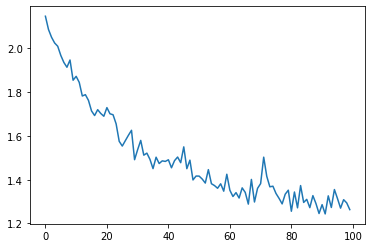

In [23]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

### Evaluating the Results

To see how well the network performs on different categories, we will create a confusion matrix, indicating for every actual language (rows) which language the network guesses (columns). To calculate the confusion matrix a bunch of samples are run through the network with evaluate(), which is the same as train() minus the backprop.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator


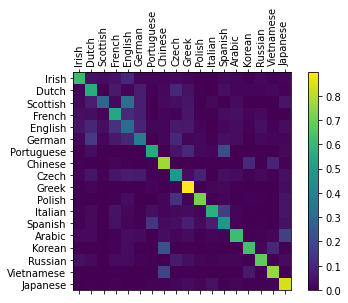

In [25]:
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

def evaluate(line_tensor):
    hidden = rnn.initHidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    
    return output

for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1
    
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

You can pick out bright spots off the main axis that show which languages it guesses incorrectly, e.g. Chinese for Korean, and Spanish for Italian. It seems to do very well with Greek, and very poorly with English (perhaps because of overlap with other languages).

### Running on User Input

In [31]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))
        
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []
        
        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print(value, all_categories[category_index])
            predictions.append([value, all_categories[category_index]])
        
predict('Dovesky')
predict('Jackson')
predict('Himawari')
    


> Dovesky
-0.5634479522705078 Czech
-1.0362825393676758 Russian
-3.6612966060638428 Polish

> Jackson
-1.0800515413284302 English
-1.9094139337539673 Russian
-1.9120439291000366 Scottish

> Himawari
-0.08060972392559052 Japanese
-3.649590492248535 Polish
-4.34324312210083 English


### Exercises
> Try with a different dataset of line -> category, for example:
Any word -> language
First name -> gender
Character name -> writer
Page title -> blog or subreddit

>Get better results with a bigger and/or better shaped network
Add more linear layers
Try the nn.LSTM and nn.GRU layers
Combine multiple of these RNNs as a higher level network